In [2]:
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt

from utils.funs import scores, scores_trace 

from transformers import AutoModel, BertModel, DistilBertModel


In [3]:
def getscoresBERT(d,l,h,dh,model):
    """
    Let Q and K be
    Q = X @ W_q ; K = X @ W_k

    it follows that the dot product between queries and keys is 
    Q @ K^T = X @ (W_q @ W_k^T) @ X^T = X @ M @ X^T 

    where M is a square matrix \in R^{d,d}, that can be decomposed into its
    symmetric and skew-symmetric part S and N, respectively,
    M = 1/2 * (M + M^T) + 1/2 * (M - M^T) = S + N

    important: nn.Linear.weight returns the learnable weights of the module as
    (out_features,in_features), then we can access the matrix W_q or 
    W_k as nn.Linear.weight^T

    Args:
        - d (int) : embeddding dimension.
        - l (int) : total number of layers
        - h (int) : number of heads.
        - dh (int) : embedding dimension per head.
        - model () : full model.

    Returns:
        - SList (numpy ndarray) : List of Symmetric (S) scores.
        - NList (numpy ndarray) : List of Skew-symmetric (N) scores.
    """

    SList = np.zeros((l,h))
    NList = np.zeros((l,h))
    
    # retrieve all BertLayer instances (the encoder in each layer)
    layers = model.encoder.layer

    for i, layer in enumerate(layers):

        # access self-attention module within layer
        self_attention = layer.attention.self

        # access W_q and W_k: transpose the weight matrix and split into heads
        Wq = self_attention.query._parameters["weight"].T.view(d,h,dh).detach().numpy()
        Wk = self_attention.key._parameters["weight"].T.view(d,h,dh).detach().numpy()

        for j in range(h):
            
            # compute symmetry scores
            SList[i,j] = scores_trace(Wq[:,j,:], Wk[:,j,:])

    return  SList, NList

def getscoresDistillBERT(d,l,h,dh,model):
    """ 
    Args:
        - d (int) : embeddding dimension.
        - l (int) : total number of layers
        - h (int) : number of heads.
        - dh (int) : embedding dimension per head.
        - model () : full model.

    Returns:
        - SList (numpy ndarray) : List of Symmetric (S) scores.
        - NList (numpy ndarray) : List of Skew-symmetric (N) scores.
    """

    SList = np.zeros((l,h))
    NList = np.zeros((l,h))

    # retrieve all BertLayer instances (the encoder in each layer)
    layers = model.transformer.layer

    for i, layer in enumerate(layers):

        # access self-attention module within layer
        self_attention = layer.attention

        # access W_q and W_k: transpose the weight matrix and split into heads
        Wq = self_attention.q_lin._parameters["weight"].T.view(d,h,dh).detach().numpy()
        Wk = self_attention.k_lin._parameters["weight"].T.view(d,h,dh).detach().numpy()

        for j in range(h):
            
            # compute symmetry scores
            SList[i,j] = scores_trace(Wq[:,j,:], Wk[:,j,:])

    return  SList, NList

In [4]:
"""
- KEY (str): model name
- VALUES (list): [layers (int), 
                  embedding dim (int), 
                  heads (int), 
                  head dim (int), 
                  S scores, 
                  N scores]
"""

if os.path.isfile('../../_data/fig_scores/BERT-query-key.pkl'):
    with open('../../_data/fig_scores/BERT-query-key.pkl', 'rb') as file:
        models = pickle.load(file)
else: models = {}

In [5]:
""" 
BERT models 
 - MODEL: Bidirectional, Encoder-only Transformer
 - DATASETS: BookCorpus & English Wikipedia
 - OBJECTIVES: Masked Language Modeling (MLM), Next Sentence Prediction (NSP)
 - METRICS: perplexity, cross-entropy

 MLM: randomly masked some words in the sentence, predict masked words with cross-entropy 
 over the vocabulary 
 NSP: 

The idea is that these models have a better understanding of context, where each word is represented as a 
linear combination of all the other words in the sentence, bi-directionally.
"""
dh = 64

'BERT tiny (l = 2, d = 128, h = 2 ; 4.40M parameters)'
l = 2
d = 128
h = d // dh
model = AutoModel.from_pretrained("google/bert_uncased_L-2_H-128_A-2")
S, N = getscoresBERT(d,l,h,dh,model)
models['BERTtiny'] = [l,d,h,dh,S,N]

'BERT mini (l = 4, d = 256, h = 4 ; 11.3M parameters)'
l = 4
d = 256
h = d // dh
model = AutoModel.from_pretrained("google/bert_uncased_L-4_H-256_A-4")
S, N = getscoresBERT(d,l,h,dh,model)
models['BERTmini'] = [l,d,h,dh,S,N]

'BERT small (l = 4, d = 512, h = 8 ; 29.1M parameters)'
l = 4
d = 512
h = d // dh
model = AutoModel.from_pretrained("google/bert_uncased_L-4_H-512_A-8")
S, N = getscoresBERT(d,l,h,dh,model)
models['BERTsmall'] = [l,d,h,dh,S,N]

'BERT medium (l = 8, d = 512, h = 8 ; 41.7M parameters)'
l = 8
d = 512
h = d // dh
model = AutoModel.from_pretrained("google/bert_uncased_L-8_H-512_A-8")
S, N = getscoresBERT(d,l,h,dh,model)
models['BERTmedium'] = [l,d,h,dh,S,N]

'BERT base (l = 12, d = 768, h = 12 ; 110M parameters)'
l = 12
d = 768
h = d // dh
model = BertModel.from_pretrained("bert-base-uncased")
S, N = getscoresBERT(d,l,h,dh,model)
models['BERTbase'] = [l,d,h,dh,S,N]

'BERT large (l = 24, d = 1024, h = 16 ; 340M parameters)'
l = 24
d = 1024
h = d // dh
model = BertModel.from_pretrained("bert-large-uncased")
S, N = getscoresBERT(d,l,h,dh,model)
models['BERTlarge'] = [l,d,h,dh,S,N]

'BERT large (masking) (l = 24, d = 1024, h = 16 ; 340M parameters)'
l = 24
d = 1024
h = d // dh
model = BertModel.from_pretrained("bert-large-uncased-whole-word-masking")
S, N = getscoresBERT(d,l,h,dh,model)
models['BERTlarge_mask'] = [l,d,h,dh,S,N]

'DistillBERT base model (l = 6, d = 768, h = 12 ; tot num parameters 66M)'
l = 6
d = 768
h = d // dh
model = DistilBertModel.from_pretrained("distilbert-base-uncased")
S, N = getscoresDistillBERT(d,l,h,dh,model)
models['DistillBERT'] = [l,d,h,dh,S,N]

'save'
with open('../../_data/fig_scores/BERT-query-key.pkl', 'wb') as file:
    pickle.dump(models, file)

/opt/homebrew/Caskroom/miniconda/base/envs/attention-geometry/lib/python3.11/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [7]:
models

{'BERTtiny': [2,
  128,
  2,
  64,
  array([[0.86188051, 0.75642419],
         [0.81139982, 0.82361335]]),
  array([[0., 0.],
         [0., 0.]])],
 'BERTmini': [4,
  256,
  4,
  64,
  array([[0.66545959, 0.8564215 , 0.75080028, 0.70505722],
         [0.65995148, 0.87255174, 0.65866521, 0.74894702],
         [0.63108094, 0.62941746, 0.59428763, 0.69167534],
         [0.80328146, 0.5613392 , 0.59943383, 0.62696385]]),
  array([[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]])],
 'BERTsmall': [4,
  512,
  8,
  64,
  array([[0.68939681, 0.86262447, 0.72839925, 0.69402914, 0.67406961,
          0.52659582, 0.66176596, 0.58258984],
         [0.75830778, 0.6069207 , 0.57639582, 0.6118694 , 0.61190871,
          0.56698551, 0.89987844, 0.56562887],
         [0.55009348, 0.55850313, 0.52554737, 0.5880567 , 0.5790714 ,
          0.54486635, 0.5542192 , 0.52361989],
         [0.53655132, 0.79039574, 0.5957802 , 0.59778452, 0.78597981,
          0

(0.0, 1.0)

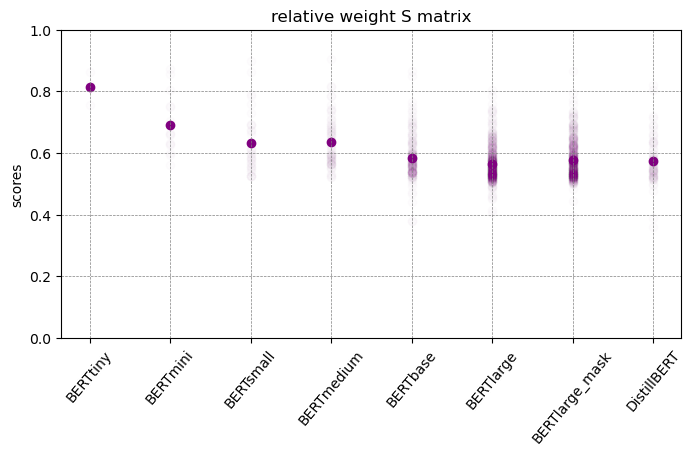

In [8]:
with open('../../_data/fig_scores/BERT-query-key.pkl', 'rb') as file:
    models = pickle.load(file)

SList = [models[key][-2].flatten() for key in list(models.keys())]
NList = [models[key][-1].flatten() for key in list(models.keys())]
names = list(models.keys())

plt.figure(figsize=(8,4))

for i, model in enumerate(SList):
    
    plt.scatter(i*np.ones(SList[i].size),(SList[i].flatten()),color='purple',alpha=.01)
    plt.scatter(i,(SList[i].flatten()).mean(),color='purple')
    
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.title('relative weight S matrix')
plt.ylabel('scores')
plt.xticks(np.arange(len(names)),names)
plt.xticks(rotation=50)
plt.ylim(0,1)

In [11]:
SList[-1]**2

array([0.63978498, 0.58688664, 0.53590401, 0.63170512, 0.63252173,
       0.60929767, 0.54570389, 0.57174327, 0.69139511, 0.6606663 ,
       0.58056083, 0.59503291, 0.38890916, 0.63623684, 0.56154581,
       0.65942344, 0.54888765, 0.47702037, 0.80461737, 0.58147259,
       0.55518204, 0.35898394, 0.58167414, 0.65139184, 0.54511932,
       0.52403996, 0.56704853, 0.8193045 , 0.58104806, 0.71413475,
       0.51046589, 0.49882579, 0.53931855, 0.71993821, 0.5494123 ,
       0.49653891, 0.51859283, 0.52271787, 0.55637335, 0.54236811,
       0.5221081 , 0.63722736, 0.51050379, 0.53320108, 0.51417645,
       0.52218313, 0.56530407, 0.54395199, 0.59557125, 0.52679599,
       0.57480052, 0.56938516, 0.57043197, 0.58000199, 0.67702168,
       0.55622558, 0.61177126, 0.51611089, 0.52176567, 0.68740159,
       0.52527023, 0.5954431 , 0.54053252, 0.52849191, 0.54329849,
       0.57014182, 0.53870774, 0.56928514, 0.62410644, 0.54111902,
       0.54988097, 0.58772456])